In [42]:
# import necessary libraries
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras import backend as K

"""
 Attempted to create a custom loss function to penalize predictions but the results seems were not accurate
"""
def start_date_penalty(y_true, y_pred):
    # Extract the year, month, and day from the true labels
    y_true_year = y_true[:, 2]
    y_true_month = y_true[:, 1]
    y_true_day = y_true[:, 0]
    y_true_lng = y_true[:, 3]
    y_true_lat = y_true[:, 4]
    y_true_dis = y_true[:, 5]

    # Extract the year, month, and day from the predicted labels
    y_pred_year = y_pred[:, 2]
    y_pred_month = y_pred[:, 1]
    y_pred_day = y_pred[:, 0]
    y_pred_lng = y_pred[:, 3]
    y_pred_lat = y_pred[:, 4]
    y_pred_dis = y_pred[:, 5]

    # Calculate the mean squared error for each of the year, month, and day
    mse_year = tf.keras.losses.mean_squared_error(y_true_year, y_pred_year)
    mse_month = tf.keras.losses.mean_squared_error(y_true_month, y_pred_month)
    mse_day = tf.keras.losses.mean_squared_error(y_true_day, y_pred_day)
    mse_lng = tf.keras.losses.mean_squared_error(y_true_lng, y_pred_lng)
    mse_lat = tf.keras.losses.mean_squared_error(y_true_lat, y_pred_lat)
    mse_dis = tf.keras.losses.mean_squared_error(y_true_dis, y_pred_dis)
    
    # Calculate the penalty for predictions outside of the desired range
    penalty = K.sum(K.cast(K.greater(y_pred_year, 2025), "float32") +
                     K.cast(K.less(y_pred_year, 2022), "float32")  +
                     K.cast(K.greater(y_pred_month, 12), "float32") +
                     K.cast(K.less(y_pred_month, 1), "float32") +
                     K.cast(K.greater(y_pred_day, 31), "float32") +
                     K.cast(K.less(y_pred_day, 1), "float32") +
                     K.cast(K.greater(y_pred_lng, 180), "float32") +
                     K.cast(K.less(y_pred_lng, -180), "float32") +
                     K.cast(K.greater(y_pred_lat, 90), "float32") +
                     K.cast(K.less(y_pred_lat, -90), "float32") +
                     K.cast(K.greater(y_pred_dis, 0), "float32") +
                     K.cast(K.less(y_pred_dis, 6), "float32")) * 1000.0

    # Return the total loss
    return mse_year + mse_month + mse_day + penalty

# load the data into a Pandas DataFrame
df = pd.read_csv("Dataset/1900_2021_DISASTERS_INTERPOLATED.csv", index_col=0)

# Format the start date column
df['Start Date'] = pd.to_datetime(df['Start Date'], format="%Y/%m/%d")

le = LabelEncoder() 
df['Disaster Type']= le.fit_transform(df['Disaster Type'])

# Extract the year, month, and day values into separate columns
df['Start Year'] = df['Start Date'].dt.year
df['Start Month'] = df['Start Date'].dt.month
df['Start Day'] = df['Start Date'].dt.day

# select the features and target variables
X = df[["Disaster Subgroup", "Disaster Subtype", "Disaster Subsubtype", "Country", "ISO", "Region", "Continent", "Location", "Timezone", "River Basin"]]

y = df[["Start Year", "Start Month", "Start Day", "Longitude", "Latitude", "Disaster Type"]]

# encode categorical variables and scale numeric variables
X = pd.get_dummies(X)
X = (X - X.mean()) / X.std()

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the input features and transform them
X_scaled = scaler.fit_transform(X)

# split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

learning_rate = 0.01
regularization_strength = 0.01

# # build the model
# model = Sequential()
# model.add(Dense(64, input_dim=X.shape[1], activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
# model.add(Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
# model.add(Dense(6))

model = Sequential()
model.add(Dense(64, input_dim=X.shape[1], kernel_regularizer=tf.keras.regularizers.l2(regularization_strength)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(Dense(64, kernel_regularizer=tf.keras.regularizers.l2(regularization_strength)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(Dense(6))

optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae', 'mse'])

# # compile model using the SGD optimizer and the mean squared error loss function
# loss_fn = tf.keras.losses.MeanSquaredError(reduction='sum')
# #optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
# model.compile(loss=loss_fn, optimizer="adam", metrics=[MeanAbsoluteError(), MeanSquaredError()])

# train the model
# history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))


# evaluate the model on the test set
y_pred = model.predict(X_test)
mae = model.evaluate(X_test, y_test, verbose=0)[1]
#rmse = mean_squared_error(y_test, y_pred) ** 0.5
print("Mean Absolute Error: {:.4f}".format(mae))
#print(f"Root Mean Squared Error: {rmse:.2f}")



# df1 = pd.read_csv("Dataset/2022_DISASTERS_TARGET.csv", index_col=0)

# df1 = df1.dropna()

# df1 = df1[["Disaster Subgroup", "Disaster Subtype", "Disaster Subsubtype", "Country", "ISO", "Region", "Continent", "Location", "River Basin"]]

# # make a prediction on new, unseen data
# X_test = df1

# y_pred = model.predict(X_test)

# # get the predicted year, month, and day
# predicted_year = int(y_pred[0])
# predicted_month = int(y_pred[1])
# predicted_day = int(y_pred[2])

# # create a datetime object using the predicted date parts
# predicted_date = datetime.datetime(predicted_year, predicted_month, predicted_day)

# # print the predicted date
# print(f"Predicted Start Date: {predicted_date}")

Epoch 1/100


C:\Users\l\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


141/141 [==============================] - 2s 10ms/step - loss: 612790.2500 - mae: 333.7368 - mse: 612775.9375 - val_loss: 542750.2500 - val_mae: 311.0888 - val_mse: 542712.4375
Epoch 2/100
141/141 [==============================] - 1s 8ms/step - loss: 302956.4375 - mae: 230.6568 - mse: 302895.3750 - val_loss: 124219.8125 - val_mae: 152.5387 - val_mse: 124135.8906
Epoch 3/100
141/141 [==============================] - 1s 8ms/step - loss: 53497.5625 - mae: 93.4721 - mse: 53403.8789 - val_loss: 15447.0977 - val_mae: 55.2672 - val_mse: 15345.1035
Epoch 4/100
141/141 [==============================] - 1s 8ms/step - loss: 15957.2959 - mae: 52.1475 - mse: 15849.4775 - val_loss: 10413.1680 - val_mae: 46.8990 - val_mse: 10299.1299
Epoch 5/100
141/141 [==============================] - 1s 8ms/step - loss: 14514.5186 - mae: 50.4384 - mse: 14397.1895 - val_loss: 10408.1309 - val_mae: 46.2480 - val_mse: 10287.2861
Epoch 6/100
141/141 [==============================] - 1s 9ms/step - loss: 14393.517

(0.0, 100.0)

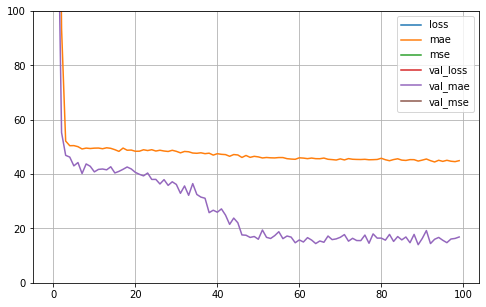

In [54]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 100)

In [55]:
for i in range(y_pred.shape[0]):
    predicted_year = int(y_pred[i][0])
    predicted_month = int(y_pred[i][2])
    predicted_day = int(y_pred[i][1])
    predicted_lng = int(y_pred[i][3])
    predicted_lat = int(y_pred[i][4])
    predicted_dis = int(y_pred[i][5])
    
    if((2022 <= predicted_year <= 2025) and (0 <= predicted_dis <= 6) ):
        print(f"Disaster type: {predicted_dis} | Start Date: {predicted_year}-{predicted_month}-{predicted_day} | Coordinates: ({predicted_lng},{predicted_lat})")
    # else:
    #     print(f"Prediction outside of the desired range: {predicted_year}-{predicted_month}-{predicted_day} | Coordinates: ({predicted_lng},{predicted_lat})")
    
    # create a datetime object using the predicted date parts
    #predicted_date = datetime.datetime(predicted_year, predicted_month, predicted_day)
    # print the predicted date

<p> The model is producing predictions that are close to the mean of the training data indicating that the network is underfitting the data.</p>

In [56]:
# import necessary libraries for plotting
import matplotlib.pyplot as plt

# initialize lists to store the epochs and mean absolute errors
epochs = []
maes = []

# loop through the history object of your model and extract the epochs and mean absolute errors
for epoch in range(len(history.history['mean_absolute_error'])):
    epochs.append(epoch)
    maes.append(history.history['mean_absolute_error'][epoch])

# create a scatter plot using the epochs and mean absolute errors lists
plt.scatter(epochs, maes)

# add x and y labels and a title to the plot
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Epochs vs Mean Absolute Error')

KeyError: 'mean_absolute_error'